In [ ]:
import pm4py
import pandas as pd

# Data exploration

## Load event log

In [ ]:
log = pm4py.read_xes("/Users/evamartin/Desktop/MDS/curs1/PODS/MDS-PODS-Proj1/Full_BPI_Challenge_2019.xes")

/Users/evamartin/.pyenv/versions/3.11.6/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 251734/251734 [00:44<00:00, 5645.54it/s]


## Filter event log

In [49]:
filtered_logs = {}
for item_category in log["case:Item Category"].unique():
    category_log = log[log["case:Item Category"] == item_category]
    for document_type in category_log["case:Document Type"].unique():
        category_df_by_document = category_log[
            category_log["case:Document Type"] == document_type
        ]
        filtered_logs[item_category + "_" + document_type] = category_df_by_document

allowed_start_act = {
    "3-way match, invoice before GR_EC Purchase order": [
        "SRM: Created",  # 796,
        "Vendor creates invoice",  #: 29,
        "Vendor creates debit memo",  #: 4,
    ],
    "3-way match, invoice before GR_Standard PO": [
        "Create Purchase Order Item",  #: 174844,
        "Vendor creates invoice",  #: 2634,
        "Create Purchase Requisition Item",  #: 42507,
        "Change Approval for Purchase Order",  #: 64,
        "Vendor creates debit memo",  #: 107,
        "Change Currency",  #: 2,
        "Release Purchase Order",  #: 22,
    ],
    "3-way match, invoice before GR_Framework order": [
        "Create Purchase Order Item"
    ],  # 1
    "3-way match, invoice after GR_EC Purchase order": [
        "SRM: Created",  #: 564,
        "Vendor creates invoice",  #: 44,
        "Vendor creates debit memo",  #: 2,
        "Create Purchase Order Item",  #: 1,
    ],
    "3-way match, invoice after GR_Standard PO": [
        "Create Purchase Order Item",  #: 12615,
        "Create Purchase Requisition Item",  #: 1219,
        "Vendor creates invoice",  #: 242,
        "Vendor creates debit memo",  #: 1,
    ],
    "3-way match, invoice after GR_Framework order": [
        "Vendor creates invoice",  #: 70,
        "Create Purchase Order Item",  #: 419,
        "Vendor creates debit memo",  #: 5,
    ],
    "Consignment_Standard PO": [
        "Create Purchase Order Item",  #: 11698,
        "Create Purchase Requisition Item",  #: 2800
    ],
    "2-way match_Framework order": [
        "Vendor creates invoice",  #: 438,
        "Change Approval for Purchase Order",  #: 314,
        "Vendor creates debit memo",  #: 3,
        "Create Purchase Order Item",  #: 289,
    ],
}

allowed_end_act = {
    "3-way match, invoice before GR_EC Purchase order": [
        "Clear Invoice",  #: 713,
        # "SRM: Transaction Completed",  #: 1,
        # "Record Invoice Receipt",  #: 45,
        # "Record Goods Receipt",  #: 39,
        # "Delete Purchase Order Item",  #: 4,
        # "SRM: In Transfer to Execution Syst.",  #: 4,
        # "Create Purchase Order Item",  #: 4,
        # "Cancel Invoice Receipt",  #: 3,
        # "Change Final Invoice Indicator",  #: 2,
        # "Remove Payment Block",  #: 5,
        # "SRM: Change was Transmitted",  #: 9,
    ],
    "3-way match, invoice before GR_Standard PO": [
        "Clear Invoice",  #: 171191,
        # "Record Invoice Receipt",  #: 21413,
        "Delete Purchase Order Item",  #: 7409,
        # "Cancel Invoice Receipt",  #: 1261,
        # "Change Quantity",  #: 406,
        # "Change Price",  #: 443,
        # "Record Goods Receipt",  #: 7288,
        # "Change Delivery Indicator",  #: 415,
        # "Block Purchase Order Item",  #: 167,
        # "Create Purchase Order Item",  #: 3714,
        # "Cancel Goods Receipt",  #: 209,
        # "Change Approval for Purchase Order",  #: 797,
        # "Remove Payment Block",  #: 5136,
        # "Change Currency",  #: 1,
        # "Reactivate Purchase Order Item",  #: 11,
        # "Cancel Subsequent Invoice",  #: 21,
        # "Change Storage Location",  #: 19,
        # "Vendor creates debit memo",  #: 2,
        # "Record Subsequent Invoice",  #: 9,
        # "Vendor creates invoice",  #: 49,
        # "Receive Order Confirmation",  #: 215,
        # "Release Purchase Order",  #: 1,
        # "Change payment term",  #: 1,
        # "Update Order Confirmation",  #: 2,
    ],
    "3-way match, invoice before GR_Framework order": [
        "Delete Purchase Order Item",  #: 1
    ],
    "3-way match, invoice after GR_EC Purchase order": [
        # "SRM: Transfer Failed (E.Sys.)",  #: 44,
        # "SRM: Change was Transmitted",  #: 38,
        # "Change Delivery Indicator",  #: 14,
        "Clear Invoice",  #: 347,
        # "SRM: In Transfer to Execution Syst.",  #: 26,
        # "Record Service Entry Sheet",  #: 12,
        # "Create Purchase Order Item",  #: 28,
        # "Record Invoice Receipt",  #: 67,
        # "Vendor creates debit memo",  #: 1,
        # "Change Final Invoice Indicator",  #: 1,
        # "SRM: Transaction Completed",  #: 5,
        # "Remove Payment Block",  #: 4,
        # "Cancel Invoice Receipt",  #: 4,
        # "Cancel Goods Receipt",  #: 1,
        # "Delete Purchase Order Item",  #: 4,
        # "Change Price",  #: 2,
        # "SRM: Deleted",  #: 9,
        # "Record Goods Receipt",  #: 4,
    ],
    "3-way match, invoice after GR_Standard PO": [
        "Clear Invoice",  #: 8674,
        # "Record Invoice Receipt",  #: 1171,
        # "Set Payment Block",  #: 58,
        # "Record Goods Receipt",  #: 2306,
        # "Record Service Entry Sheet",  #: 883,
        # "Cancel Invoice Receipt",  #: 77,
        "Delete Purchase Order Item",  #: 261,
        # "Cancel Goods Receipt",  #: 165,
        # "Remove Payment Block",  #: 252,
        # "Change Delivery Indicator",  #: 19,
        # "Create Purchase Order Item",  #: 154,
        # "Change Price",  #: 26,
        # "Vendor creates invoice",  #: 3,
        # "Change Quantity",  #: 20,
        # "Change Approval for Purchase Order",  #: 6,
        # "Cancel Subsequent Invoice",  #: 2,
    ],
    "3-way match, invoice after GR_Framework order": [
        # "Cancel Invoice Receipt",  #: 3,
        # "Change Price",  #: 46,
        "Clear Invoice",  #: 237,
        # "Delete Purchase Order Item",  #: 37,
        # "Record Invoice Receipt",  #: 92,
        # "Create Purchase Order Item",  #: 38,
        # "Record Service Entry Sheet",  #: 26,
        # "Record Goods Receipt",  #: 9,
        # "Cancel Goods Receipt",  #: 2,
        # "Cancel Subsequent Invoice",  #: 1,
        # "Vendor creates invoice",  #: 2,
        # "Reactivate Purchase Order Item",  #: 1,
    ],
    "Consignment_Standard PO": [
        # "Change Quantity",  #: 99,
        "Record Goods Receipt",  #: 13130,
        "Delete Purchase Order Item",  #: 404,
        # "Change Delivery Indicator",  #: 270,
        # "Receive Order Confirmation",  #: 17,
        # "Reactivate Purchase Order Item",  #: 2,
        # "Cancel Goods Receipt",  #: 63,
        # "Change Price",  #: 12,
        # "Update Order Confirmation",  #: 1,
        # "Change Storage Location",  #: 1,
        # "Create Purchase Order Item",  #: 499,
    ],
    "2-way match_Framework order": [
        "Change Approval for Purchase Order",  #: 543,
        "Clear Invoice",  #: 166,
        # "Record Invoice Receipt",  #: 303,
        # "Vendor creates debit memo",  #: 2,
        # "Vendor creates invoice",  #: 14,
        # "Delete Purchase Order Item",  #: 3,
        # "Set Payment Block",  #: 3,
        # "Create Purchase Order Item",  #: 10,
    ],
}

overall_rows = 0
for name, filtered_log in filtered_logs.items():
    print(name)
    print(len(filtered_log))
    overall_rows += len(filtered_log)
    print("startactivities")
    print(pm4py.get_start_activities(filtered_log))
    print("endactivities")
    print(pm4py.get_end_activities(filtered_log))
    # filtered_log = pm4py.filtering.filter_start_activities(filtered_log, [])
    filtered_log = pm4py.filtering.filter_end_activities(
        filtered_log, allowed_end_act[name]
    )
   
    name = name.replace(" ", "").replace(",", "_").replace("-", "_")
    # filtered_log.to_csv(f"{name}.csv", index=False)
    pm4py.write_xes(filtered_log, f"{name}.xes")


print(overall_rows)
print(len(log))


3-way match, invoice before GR_EC Purchase order
10170
startactivities
{'SRM: Created': 796, 'Vendor creates invoice': 29, 'Vendor creates debit memo': 4}
endactivities
{'Clear Invoice': 713, 'SRM: Transaction Completed': 1, 'Record Invoice Receipt': 45, 'Record Goods Receipt': 39, 'Delete Purchase Order Item': 4, 'SRM: In Transfer to Execution Syst.': 4, 'Create Purchase Order Item': 4, 'Cancel Invoice Receipt': 3, 'Change Final Invoice Indicator': 2, 'Remove Payment Block': 5, 'SRM: Change was Transmitted': 9}


exporting log, completed traces :: 100%|██████████| 713/713 [00:00<00:00, 4746.15it/s]


3-way match, invoice before GR_Standard PO
1224536
startactivities
{'Create Purchase Order Item': 174844, 'Vendor creates invoice': 2634, 'Create Purchase Requisition Item': 42507, 'Change Approval for Purchase Order': 64, 'Vendor creates debit memo': 107, 'Change Currency': 2, 'Release Purchase Order': 22}
endactivities
{'Clear Invoice': 171191, 'Record Invoice Receipt': 21413, 'Delete Purchase Order Item': 7409, 'Cancel Invoice Receipt': 1261, 'Change Quantity': 406, 'Change Price': 443, 'Record Goods Receipt': 7288, 'Change Delivery Indicator': 415, 'Block Purchase Order Item': 167, 'Create Purchase Order Item': 3714, 'Cancel Goods Receipt': 209, 'Change Approval for Purchase Order': 797, 'Remove Payment Block': 5136, 'Change Currency': 1, 'Reactivate Purchase Order Item': 11, 'Cancel Subsequent Invoice': 21, 'Change Storage Location': 19, 'Vendor creates debit memo': 2, 'Record Subsequent Invoice': 9, 'Vendor creates invoice': 49, 'Receive Order Confirmation': 215, 'Release Purchas

exporting log, completed traces :: 100%|██████████| 178600/178600 [00:20<00:00, 8570.71it/s]


3-way match, invoice before GR_Framework order
2
startactivities
{'Create Purchase Order Item': 1}
endactivities
{'Delete Purchase Order Item': 1}


exporting log, completed traces :: 100%|██████████| 1/1 [00:00<00:00, 7516.67it/s]


3-way match, invoice after GR_EC Purchase order
12191
startactivities
{'SRM: Created': 564, 'Vendor creates invoice': 44, 'Vendor creates debit memo': 2, 'Create Purchase Order Item': 1}
endactivities
{'SRM: Transfer Failed (E.Sys.)': 44, 'SRM: Change was Transmitted': 38, 'Change Delivery Indicator': 14, 'Clear Invoice': 347, 'SRM: In Transfer to Execution Syst.': 26, 'Record Service Entry Sheet': 12, 'Create Purchase Order Item': 28, 'Record Invoice Receipt': 67, 'Vendor creates debit memo': 1, 'Change Final Invoice Indicator': 1, 'SRM: Transaction Completed': 5, 'Remove Payment Block': 4, 'Cancel Invoice Receipt': 4, 'Cancel Goods Receipt': 1, 'Delete Purchase Order Item': 4, 'Change Price': 2, 'SRM: Deleted': 9, 'Record Goods Receipt': 4}


exporting log, completed traces :: 100%|██████████| 347/347 [00:00<00:00, 2569.36it/s]


3-way match, invoice after GR_Standard PO
279293
startactivities
{'Create Purchase Order Item': 12615, 'Create Purchase Requisition Item': 1219, 'Vendor creates invoice': 242, 'Vendor creates debit memo': 1}
endactivities
{'Clear Invoice': 8674, 'Record Invoice Receipt': 1171, 'Set Payment Block': 58, 'Record Goods Receipt': 2306, 'Record Service Entry Sheet': 883, 'Cancel Invoice Receipt': 77, 'Delete Purchase Order Item': 261, 'Cancel Goods Receipt': 165, 'Remove Payment Block': 252, 'Change Delivery Indicator': 19, 'Create Purchase Order Item': 154, 'Change Price': 26, 'Vendor creates invoice': 3, 'Change Quantity': 20, 'Change Approval for Purchase Order': 6, 'Cancel Subsequent Invoice': 2}


exporting log, completed traces :: 100%|██████████| 8935/8935 [00:01<00:00, 4770.44it/s]


3-way match, invoice after GR_Framework order
27749
startactivities
{'Vendor creates invoice': 70, 'Create Purchase Order Item': 419, 'Vendor creates debit memo': 5}
endactivities
{'Cancel Invoice Receipt': 3, 'Change Price': 46, 'Clear Invoice': 237, 'Delete Purchase Order Item': 37, 'Record Invoice Receipt': 92, 'Create Purchase Order Item': 38, 'Record Service Entry Sheet': 26, 'Record Goods Receipt': 9, 'Cancel Goods Receipt': 2, 'Cancel Subsequent Invoice': 1, 'Vendor creates invoice': 2, 'Reactivate Purchase Order Item': 1}


exporting log, completed traces :: 100%|██████████| 237/237 [00:00<00:00, 1287.71it/s]


Consignment_Standard PO
36084
startactivities
{'Create Purchase Order Item': 11698, 'Create Purchase Requisition Item': 2800}
endactivities
{'Change Quantity': 99, 'Record Goods Receipt': 13130, 'Delete Purchase Order Item': 404, 'Change Delivery Indicator': 270, 'Receive Order Confirmation': 17, 'Reactivate Purchase Order Item': 2, 'Cancel Goods Receipt': 63, 'Change Price': 12, 'Update Order Confirmation': 1, 'Change Storage Location': 1, 'Create Purchase Order Item': 499}


exporting log, completed traces :: 100%|██████████| 13534/13534 [00:00<00:00, 14625.42it/s]


2-way match_Framework order
5898
startactivities
{'Vendor creates invoice': 438, 'Change Approval for Purchase Order': 314, 'Vendor creates debit memo': 3, 'Create Purchase Order Item': 289}
endactivities
{'Change Approval for Purchase Order': 543, 'Clear Invoice': 166, 'Record Invoice Receipt': 303, 'Vendor creates debit memo': 2, 'Vendor creates invoice': 14, 'Delete Purchase Order Item': 3, 'Set Payment Block': 3, 'Create Purchase Order Item': 10}


exporting log, completed traces :: 100%|██████████| 709/709 [00:00<00:00, 8472.54it/s]

1595923
1595923


## Event log analysis 

**Special focus on Clear Invoice activity**

### A. 2_waymatch_Frameworkorder

#### 1) Basic frequency analysis

In [81]:
log1 = pm4py.read_xes("/Users/evamartin/Desktop/MDS/curs1/PODS/MDS-PODS-Proj1/data_preparation/2_waymatch_Frameworkorder.xes") # <class 'pandas.core.frame.DataFrame'>
log1 = pm4py.convert_to_event_log(log1) # convert it to an event log object

parsing log, completed traces :: 100%|██████████| 709/709 [00:00<00:00, 5696.44it/s]


In [82]:
activity_name = "Clear Invoice"
activity_count = 0

for trace in log:
    for event in trace:
        if event['concept:name'] == activity_name:
            activity_count += 1

print(f"The activity '{activity_name}' occurred {activity_count} times in the log.")


The activity 'Clear Invoice' occurred 297 times in the log.


#### 2) Average time spent

In [ ]:
durations = []

for trace in log1:
    for i in range(1, len(trace)):
        event = trace[i]
        if event['concept:name'] == activity_name:
            start_time = trace[i-1]['time:timestamp']
            end_time = event['time:timestamp']
            duration = end_time - start_time
            durations.append(duration)

durations_in_minutes = [d.total_seconds() / 60 for d in durations]
print(f"Average duration for the activity '{activity_name}': {pd.Series(durations_in_minutes).mean()} minutes")


Average duration for the activity 'Clear Invoice': 11601.882154882154 minutes


#### 3) Position of activity in trace

In [86]:
positions = []

for trace in log1:
    if any(event['concept:name'] == activity_name for event in trace):
        position = [i for i, event in enumerate(trace) if event['concept:name'] == activity_name]
        positions.extend(position)

# Calculate the average position in the trace
avg_position = pd.Series(positions).mean()
print(f"Average position of '{activity_name}' in the traces: {avg_position}")


Average position of 'Clear Invoice' in the traces: 5.579124579124579


#### 4) Waiting time before activity

In [87]:
waiting_times = []

for trace in log1:
    for i in range(1, len(trace)):
        if trace[i-1]['concept:name'] == activity_name:
            start_time = trace[i]['time:timestamp']
            end_time = trace[i-1]['time:timestamp']
            waiting_time = start_time - end_time
            waiting_times.append(waiting_time)

# Convert waiting times to minutes or hours
waiting_times_in_minutes = [wt.total_seconds() / 60 for wt in waiting_times]
print(f"Average waiting time before the activity '{activity_name}': {pd.Series(waiting_times_in_minutes).mean()} minutes")


Average waiting time before the activity 'Clear Invoice': 56375.0534351145 minutes


#### 5) Some visualization

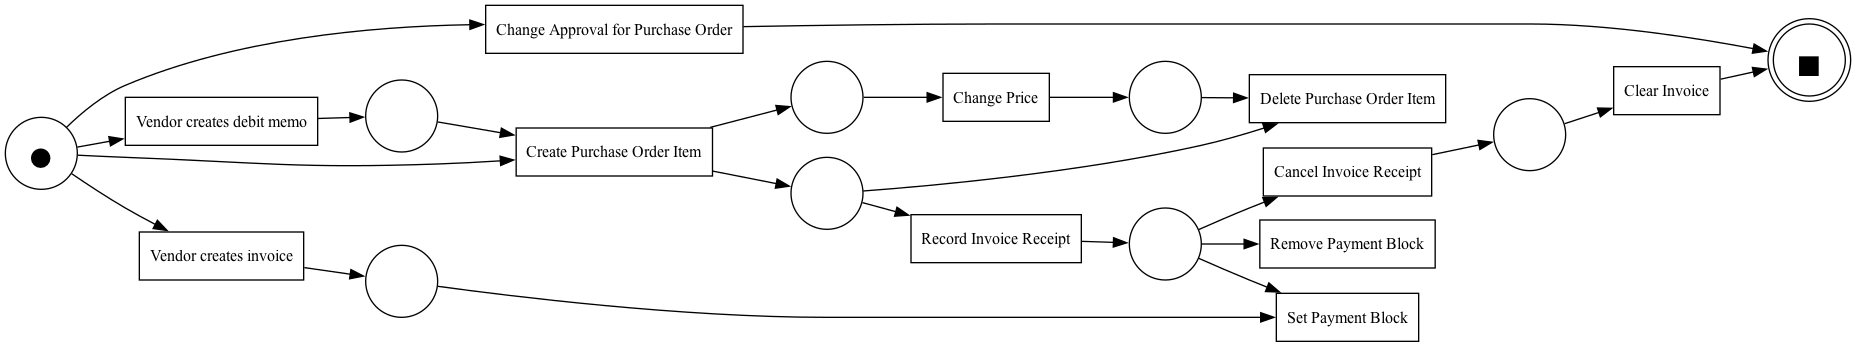

In [ ]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

# Discover the petri net using Alpha Miner 
net, initial_marking, final_marking = alpha_miner.apply(log1)

# Visualize the petri net
from pm4py.visualization.petri_net import visualizer as pn_visualizer
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)


#### 6) Attributes plots

In [ ]:
# To build the plots we convert the log into a pandas dataframe

events_df = pm4py.convert_to_dataframe(log1)

events_df

,lifecycle:transition,time:timestamp,concept:name,org:resource,User,Cumulative net worth (EUR),case:concept:name,case:variant,case:variant-index,case:creator,...,case:Purch. Doc. Category name,case:Vendor,case:Item Type,case:Item Category,case:Spend classification text,case:Source,case:Name,case:GR-Based Inv. Verif.,case:Item,case:Goods Receipt
0,complete,2017-12-16 23:59:00+00:00,Vendor creates invoice,NONE,NONE,198.0,4507075964_00010,Variant 278,278,Fluxicon Disco,...,Purchase order,vendorID_1686,Limit,2-way match,OTHER,sourceSystemID_0000,vendor_1610,False,10,False
1,complete,2018-01-03 13:47:00+00:00,Create Purchase Order Item,user_602,user_602,198.0,4507075964_00010,Variant 278,278,Fluxicon Disco,...,Purchase order,vendorID_1686,Limit,2-way match,OTHER,sourceSystemID_0000,vendor_1610,False,10,False
2,complete,2018-01-03 14:56:00+00:00,Change Approval for Purchase Order,user_603,user_603,198.0,4507075964_00010,Variant 278,278,Fluxicon Disco,...,Purchase order,vendorID_1686,Limit,2-way match,OTHER,sourceSystemID_0000,vendor_1610,False,10,False
3,complete,2018-01-04 10:04:00+00:00,Record Invoice Receipt,user_359,user_359,198.0,4507075964_00010,Variant 278,278,Fluxicon Disco,...,Purchase order,vendorID_1686,Limit,2-way match,OTHER,sourceSystemID_0000,vendor_1610,False,10,False
4,complete,2018-01-10 12:35:00+00:00,Clear Invoice,user_604,user_604,198.0,4507075964_00010,Variant 278,278,Fluxicon Disco,...,Purchase order,vendorID_1686,Limit,2-way match,OTHER,sourceSystemID_0000,vendor_1610,False,10,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4234,complete,2019-01-17 15:00:00+00:00,Change Approval for Purchase Order,user_603,user_603,1385.0,4508076348_00090,Variant 68,68,Fluxicon Disco,...,Purchase order,vendorID_1974,Limit,2-way match,NaN,sourceSystemID_0000,vendor_1898,False,90,False
4235,complete,2019-01-17 14:32:00+00:00,Create Purchase Order Item,user_602,user_602,1385.0,4508076348_00100,Variant 68,68,Fluxicon Disco,...,Purchase order,vendorID_1974,Limit,2-way match,NaN,sourceSystemID_0000,vendor_1898,False,100,False
4236,complete,2019-01-17 15:00:00+00:00,Change Approval for Purchase Order,user_603,user_603,1385.0,4508076348_00100,Variant 68,68,Fluxicon Disco,...,Purchase order,vendorID_1974,Limit,2-way match,NaN,sourceSystemID_0000,vendor_1898,False,100,False
4237,complete,2019-01-17 14:32:00+00:00,Create Purchase Order Item,user_602,user_602,1385.0,4508076348_00110,Variant 68,68,Fluxicon Disco,...,Purchase order,vendorID_1974,Limit,2-way match,NaN,sourceSystemID_0000,vendor_1898,False,110,False


In [102]:
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize the distribution of an attribute 
def plot_attribute_distribution(log, attribute_name):
    events_df = pm4py.convert_to_dataframe(log)
    
    if attribute_name not in events_df.columns:
        print(f"Attribute '{attribute_name}' not found in the log.")
        return
    
    attribute_counts = events_df[attribute_name].value_counts()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=attribute_counts.index, y=attribute_counts.values, palette="viridis")
    plt.xticks(rotation=90)
    plt.xlabel(attribute_name)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {attribute_name}')
    plt.show()

/var/folders/f9/2b844k6j623_mwcbpn3sml780000gn/T/ipykernel_5346/3747086856.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attribute_counts.index, y=attribute_counts.values, palette="viridis")


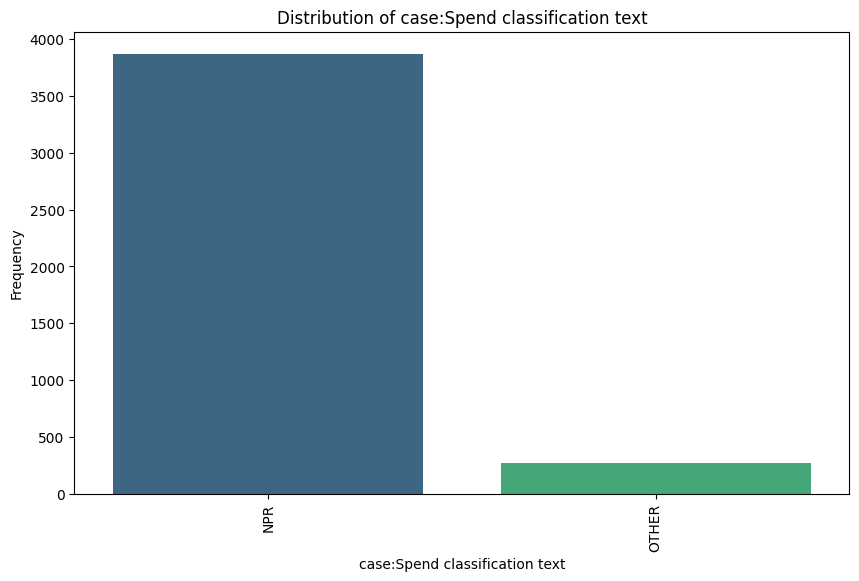

In [103]:
plot_attribute_distribution(log1, 'case:Spend classification text')

/var/folders/f9/2b844k6j623_mwcbpn3sml780000gn/T/ipykernel_5346/3747086856.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attribute_counts.index, y=attribute_counts.values, palette="viridis")


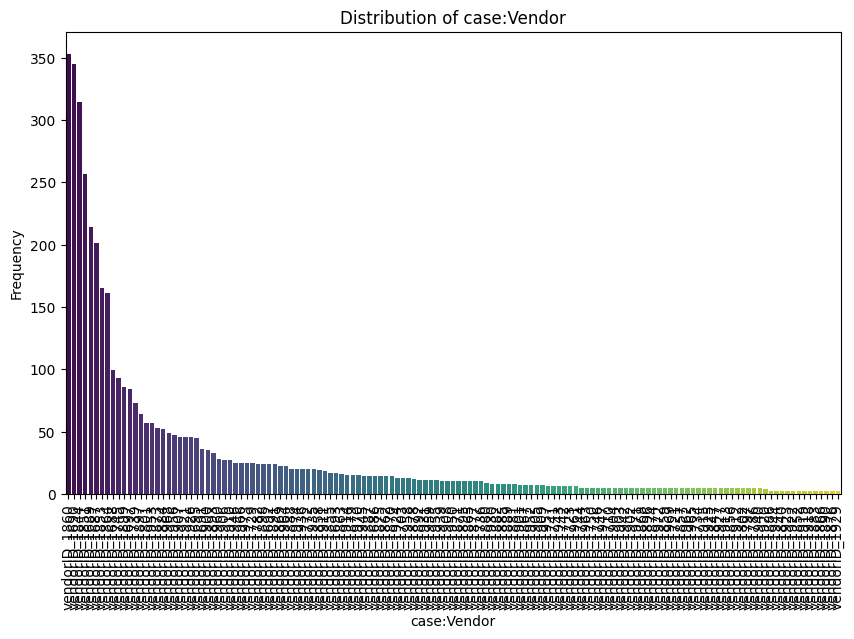

In [104]:
plot_attribute_distribution(log1, 'case:Vendor')

/var/folders/f9/2b844k6j623_mwcbpn3sml780000gn/T/ipykernel_5346/3747086856.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attribute_counts.index, y=attribute_counts.values, palette="viridis")


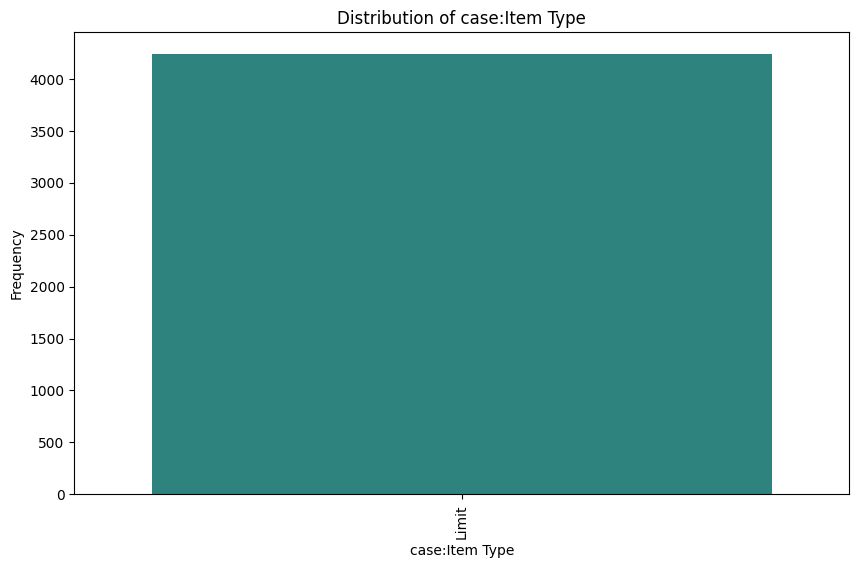

In [105]:
plot_attribute_distribution(log1, 'case:Item Type')